# Introduction

This notebook is heavily inspired by this [FastAI notebook](https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb) just with my own notes and rewrites.

Stable Diffusion is a text-to-image model, which has been integrated into the Huggingface diffusers library making it easy to generate pictures. Examples of images generate using Stability Diffusion Models can be foundcan be found on [Lexica](https://lexica.art) together with their prompts. 

Using the diffusers library on can generate images a simple as:

``` python
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")
image = pipe("An astronaught scuba diving").images[0]
```

In this notebook we're going to dig into the code behind the easy-to-use interfaces, to see what is going on under the hood. 

We'll begin by re-creating the functionality above as a scary chunk of code, and then one by one we'll inspect the different components and figure out what they do. By the end of this notebook that same sampling loop should feel like something you can tweak and modify as you like.

# Setup & Imports
To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate, but it prohibits you from deliberately producing illegal or harmful content. 

The model card provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work.

In [29]:
# Installing dependencies
#!pip install -q --upgrade transformers diffusers ftfy
#!pip install accelerate fastcore

In [31]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

Before we can download models from HuggingFace, we have to login to HuggingFace using a token. We do this here:

In [2]:
# Logging into Huggingface
torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

In [32]:
# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Making First Picture
StableDiffusionPipeline is an end-to-end diffusion inference pipeline that allows you to start generating images with just a few lines of code. Many Hugging Face libraries (along with other libraries such as scikit-learn) use the concept of a "pipeline" to indicate a sequence of steps that when combined complete some task. We'll look at the individual steps of the pipeline later -- for now though, let's just use it to see what it can do.

When we say "inference" we're referring to using an existing model to generate samples (in this case, images), as opposed to "training" (or fine-tuning) models using new data.

We use from_pretrained to create the pipeline and download the pretrained weights. We indicate that we want to use the fp16 (half-precision) version of the weights, and we tell diffusers to expect the weights in that format. This allows us to perform much faster inference with almost no discernible difference in quality. The string passed to from_pretrained in this case (CompVis/stable-diffusion-v1-4) is the [repo id](https://huggingface.co/CompVis/stable-diffusion-v1-4) of a pretrained pipeline hosted on Hugging Face Hub; it can also be a path to a directory containing pipeline weights. The weights for all the models in the pipeline will be downloaded and cached the first time you run this cell.

In [33]:
# Loading pipeline
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")

In [34]:
# Locating cached models
!ls ~/.cache/huggingface/hub/

models--bert-base-uncased		version_diffusers_cache.txt
models--CompVis--stable-diffusion-v1-4	version.txt
models--openai--clip-vit-large-patch14


If your GPU is not big enough to use pipe, run pipe.enable_attention_slicing()
as described in the docs:

    When this option is enabled, the attention module will split the input tensor in slices, to compute attention in several steps. This is useful to save some memory in exchange for a small speed decrease.

In [35]:
#pipe.enable_attention_slicing()

  0%|          | 0/50 [00:00<?, ?it/s]

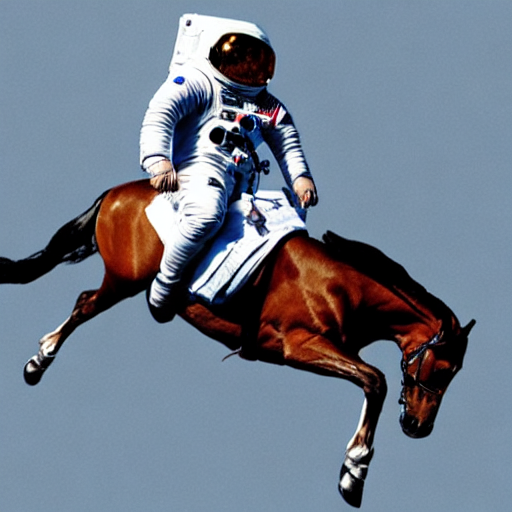

In [36]:
# Creating image
prompt = "a photograph of an astronaut riding a horse"
torch.manual_seed(1024)
pipe(prompt).images[0]

You will have noticed that running the pipeline shows a progress bar with a certain number of steps. This is because Stable Diffusion is based on a progressive denoising algorithm that is able to create a convincing image starting from pure random noise. Models in this family are known as diffusion models. We can investigate this further by only running a few inference steps.

  0%|          | 0/3 [00:00<?, ?it/s]

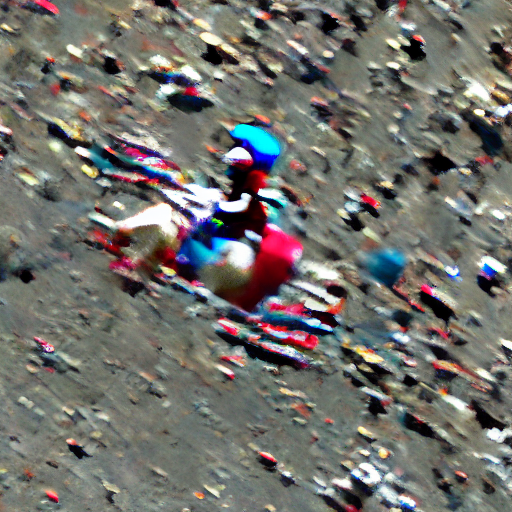

In [39]:
torch.manual_seed(1024)
pipe(prompt, num_inference_steps=3).images[0]

  0%|          | 0/7 [00:00<?, ?it/s]

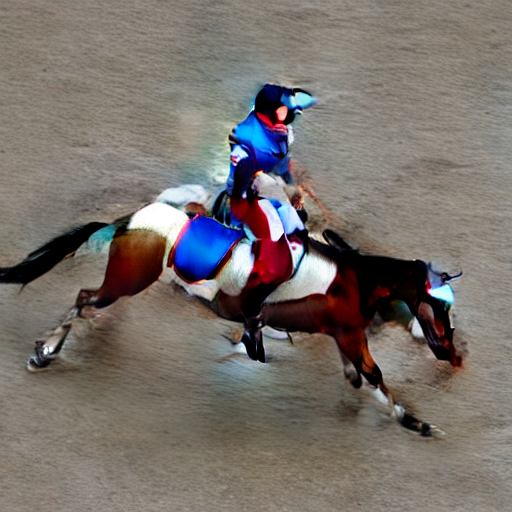

In [40]:
torch.manual_seed(1024)
pipe(prompt, num_inference_steps=7).images[0]

  0%|          | 0/16 [00:00<?, ?it/s]

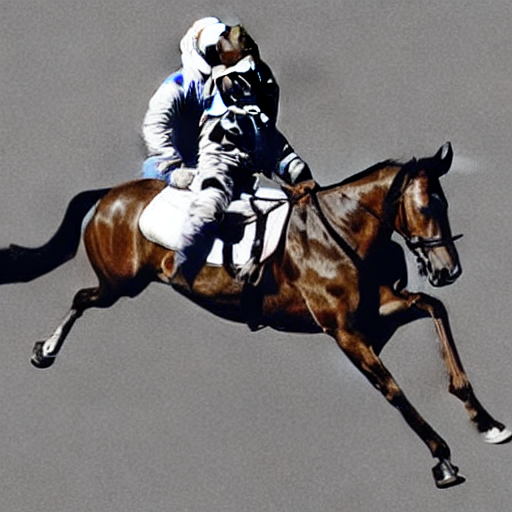

In [45]:
torch.manual_seed(1024)
pipe(prompt, num_inference_steps=16).images[0]

# Classifier-Free Guidance

# Loading Models
Here we load a model using the [Huggingface examples notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb), but we do not going into detail of what it all does.

This code will download and set up the relevant models and components we'll be using. Let's just run this for now and move on to the next section to check that it all works before diving deeper.

If you've loaded a pipeline, you can also access these components using pipe.unet, pipe.vae and so on.

In this notebook we aren't doing any memory-saving tricks - if you find yourself running out of GPU RAM, look at the pipeline code for inspiration with things like attention slicing, switching to half precision (fp16), keeping the VAE on the CPU and other modifications.

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae");

In [ ]:
# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14");
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14");

In [ ]:
# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet");

In [ ]:
# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [ ]:
# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);